# Problem 5

In [1]:
import networkx as nx
import numpy as np 
from matplotlib import pyplot as plt
from tqdm import tqdm

## Modeling backfire in opinion dynamics

### A starting point: bounded confidence model

The idea is to start from the bounded confidence model as it was formulated in the paper originally defining this results, *"Mixing beliefs among interacting agents"* (Deffuant, G., Neau, D., Amblard, F., and Weisbuch, G., 2000). 

The model assumes a fully connected network of agents where each $i$-th agent expresses an initial opinion $x_i[0] \sim \mathrm{Unif}(0,1)$.
At each timestamp, a certain number of pairwise uniformly-at-random communications among agents happen, and their opinion are updated as follows:

$$ x_{i}[t+1] = x_i[t] + \mu (x_j[t] - x_i[t]) \mathbb{I} (|x_i[t] - x_j[t]| < \epsilon)$$
$$ x_{j}[t+1] = x_j[t] + \mu (x_i[t] - x_j[t]) \mathbb{I} (|x_i[t] - x_j[t]| < \epsilon)$$

In other words, the opinion of interacting agents results in a convex combination of their previous opinions through a tunable parameter $\mu$ (it was considered within the range $(0,0.5)$ in the original paper) if their opinion are close enough: these closeness is encoded by the indicator function and the tunable parameter $\epsilon$. 

We know that this simple dynamic can easily model both consensus and polarization: 

In [2]:
np.random.seed(42)

N = 1000
G = nx.complete_graph(N)

x_0 = np.random.uniform(0,1,N)
X = x_0.copy()
eps = 0.2
mu = 0.5

T = 50
M = np.zeros((T,N))

for _ in tqdm(range(T)):
    x_ = X.copy()
    for e in np.array(G.edges)[np.random.randint(0,len(list(G.edges)), 1000)]:
        i = e[0]
        j = e[1]
        if np.abs(X[i] - X[j]) < eps:
            x_[i] = X[i] + mu * (X[j] - X[i])
            x_[j] = X[j] + mu * (X[i] - X[j])
    M[_, :] = x_
    X = x_

x_0 = np.random.uniform(0,1,N)
X = x_0.copy()
eps = 0.5
mu = 0.5

M_2 = np.zeros((T,N))

for _ in tqdm(range(T)):
    x_ = X.copy()
    for e in (np.array(G.edges)[np.random.randint(0,len(list(G.edges)), 1000)]):
        i = e[0]
        j = e[1]
        if np.abs(X[i] - X[j]) < eps:
            x_[i] = X[i] + mu * (X[j] - X[i])
            x_[j] = X[j] + mu * (X[i] - X[j])
    M_2[_, :] = x_
    X = x_

100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


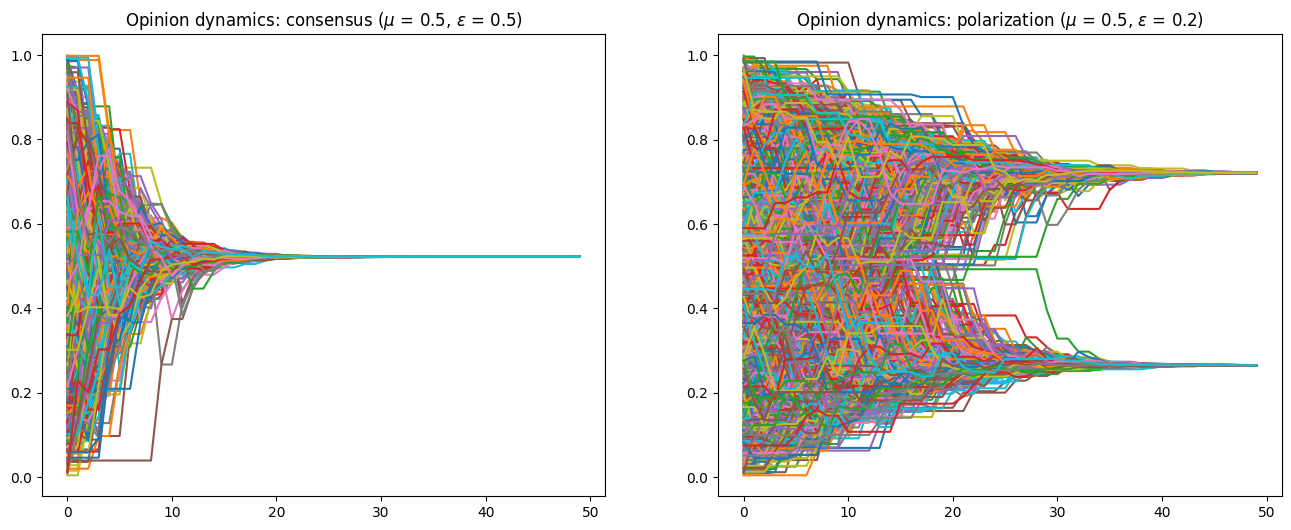

In [3]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(M_2);
axs[0].title.set_text('Opinion dynamics: consensus ($\mu$ = 0.5, $\epsilon$ = 0.5)')
axs[1].plot(M);
axs[1].title.set_text('Opinion dynamics: polarization ($\mu$ = 0.5, $\epsilon$ = 0.2)')

What is interesting to note is that polarization is just consensus reached within distinct clusters of agents: instead, when modeling backfire we are interested in getting away from consensus rather than moving towards it, in a sort of "agree to disagree" fashion. 

Still, bounded confidence is interesting because we have a very simple adaptive mechanism: now we want to make it anthagonistic. 

### From convex combination to non convex combinations: bounded backfire

The idea is to revert the previous model introducing an anthagonistic mechanism if opinions of two interacting agents are far enough: in order to do so, we can consider a very simple geometric idea. A convex combination between two point $x,y$ in a vector space yields a point $P$ lying in the portion of the line connecting this two points: the equation is just 

$$ P = x + \alpha(y-x), \ \alpha \in [0,1] $$

Clearly we have that 

$$ P \equiv x \iff \alpha = 0 $$
$$ P \equiv y \iff \alpha = 1 $$

This segment in an opinion dynamic perspective can be seen as a *neutral region* where opinions may reach consensus. 

Instead, considering the same equation we have that for $\alpha \in (- \infty, 0) $ the point $P$ lies on the half-line parallel to the one determined by $x$ and $y$ starting from $x$. Viceversa, for $\alpha \in (1, + \infty)$ we have that $P$ lies on the half-line parallel to the one determined by $x$ and $y$ starting from $y$: we can consider these two half-line as *exasperation regions*. It is clear that these parameters yields not anymore a convex combination; indeed, we can leverage this to design a diverging model. 

Given a fully connected network of agent, we consider the following dynamic on a certain number of random interactions: 

$$ x_{i}[t+1] = x_i[t]  - \mu  (x_j[t] - x_i[t]) \mathbb{I} (|x_i[t] - x_j[t]| > \eta)$$
$$ x_{j}[t+1] = x_j[t]  - \mu (x_i[t] - x_j[t]) \mathbb{I} (|x_i[t] - x_j[t]| > \eta)$$

Under the assumptions that $\mu \in (0,1)$, in this model we have that if there is disagreement $(|x_i[t] - x_j[t]| > \eta)$, the opinions are pushed towards the respective exasperation region of each agent as we previously defined them.


Let's have a look to small simulations on a network of 10 agents over a small time horizon. 

In [7]:
N = 10
G = nx.complete_graph(N)

x_0 = np.random.uniform(0,1,N)
X = x_0.copy()
eps = 0.2
eta = 0.9
mu = 0.5

T = 10
M = np.zeros((T,N))

for _ in tqdm(range(T)):
    x_ = X.copy()
    for e in np.array(G.edges)[np.random.randint(0,len(list(G.edges)), 10)]:
        i = e[0]
        j = e[1]
        
        if np.abs(X[i] - X[j]) > eta:
            x_[i] = X[i] - mu * (X[j] - X[i])
            x_[j] = X[j] - mu * (X[i] - X[j])
    M[_, :] = x_
    X = x_

eta = 0.6
mu = 0.5

T = 10
M_ = np.zeros((T,N))

for _ in tqdm(range(T)):
    x_ = X.copy()
    for e in np.array(G.edges)[np.random.randint(0,len(list(G.edges)), 10)]:
        i = e[0]
        j = e[1]

        if np.abs(X[i] - X[j]) > eta:
            x_[i] = X[i] - mu * (X[j] - X[i])
            x_[j] = X[j] - mu * (X[i] - X[j])
    M_[_, :] = x_
    X = x_

eta = 0.1
mu = 0.5

T = 10
M_2 = np.zeros((T,N))

for _ in tqdm(range(T)):
    x_ = X.copy()
    for e in np.array(G.edges)[np.random.randint(0,len(list(G.edges)), 10)]:
        i = e[0]
        j = e[1]

        if np.abs(X[i] - X[j]) > eta:
            x_[i] = X[i] - mu * (X[j] - X[i])
            x_[j] = X[j] - mu * (X[i] - X[j])
    M_2[_, :] = x_
    X = x_

100%|██████████| 10/10 [00:00<00:00, 9986.44it/s]


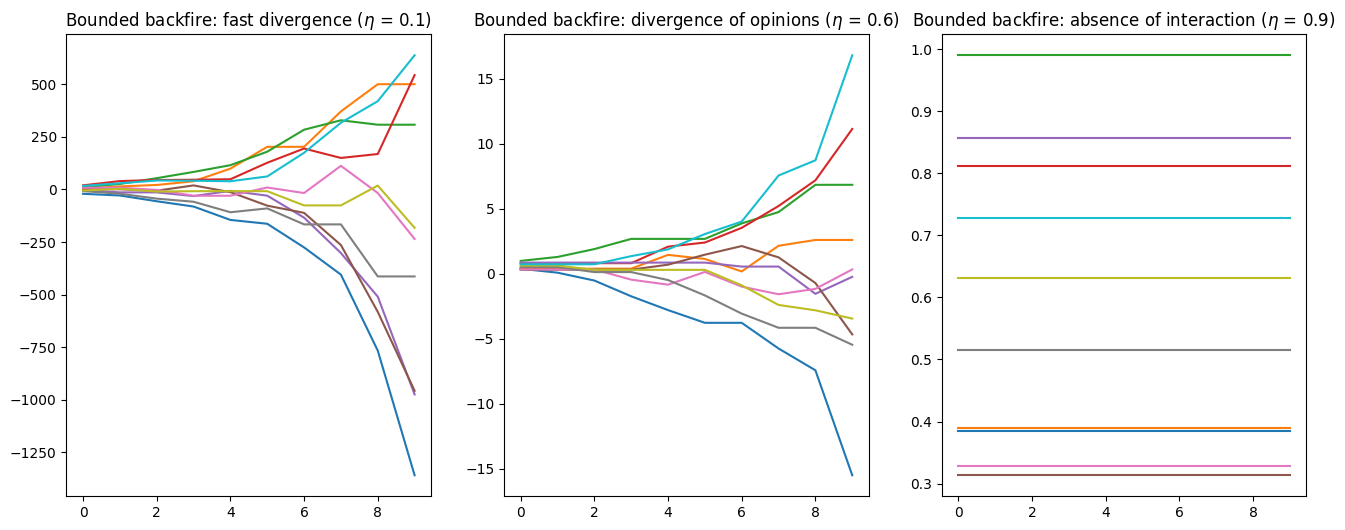

In [11]:
fig, axs = plt.subplots(1,3,figsize=(16,6))
axs[0].plot(M_2);
axs[0].title.set_text('Bounded backfire: fast divergence ($\eta$ = 0.1)')
axs[1].plot(M_);
axs[1].title.set_text('Bounded backfire: divergence of opinions ($\eta$ = 0.6)')
axs[2].plot(M);
axs[2].title.set_text('Bounded backfire: absence of interaction ($\eta$ = 0.9)')

As we can see the parameter $\eta$ influences the divergence of the opinions in its speed, up to the point that a certain value of it doesn't allow for backfire anymore. 

## The theoretical underground: heat diffusion equations, Laplacians and time varying Laplacians

Let's consider a very generic continuous time laplacian dynamic for a graph: the continuous time is easy to be analyzed theoretically.
$$
\begin{cases}
    \frac{\partial}{\partial t} x(t) = - \alpha L x(t) \\ 
    x(0) = x_0
\end{cases}
$$

The solution for this dynamic is 

$$ x(t) = e^{-\alpha L t}x_0$$

and we know that it admits a stable equilibrium in $\bar{x} = \mathbb{1}^Tx_0$ if the graph is connected: due to the spectral qualities of the laplacian, the initial state is projected over its kernel. 
The point is that with our bounded backfire we defined a non-linear laplacian that is nomore positive semidefinite through time, so we have no garancies about convergences of the related dynamics. 

### Vanilla consensus: peaceful mixing of opinions. 

Let's start considering a laplacian defined as follows:

$$ L = \mu BB^T $$ 

where we are weighting all the connections the same by $\mu \geq 0$, and $B$ is the incidence matrix encoding for the full connectivity of our model (assume also an arbitrary orientation). We also relax the stochasticity of our model, assuming that all pairs communicate at every timestamp. 

This model would be a simple consensus process, with no bounds on confidence or backfire: it would correspond to the discrete time dynamic

$$ x_{i}[t+1] = x_i[t] + \mu (x_j[t] - x_i[t]) $$
$$ x_{j}[t+1] = x_j[t] + \mu (x_i[t] - x_j[t]) $$

It would correspond to the general case we introduced before: the laplacian is constant in time and is by construction positive semidefinite, leading as we know to global consensus asymptotically. 

### Nonlinear Laplacian of bounded confidence: still convergent!

Let's go back to bounded confidence as a clarifying example: 

$$ x_{i}[t+1] = x_i[t] + \mu (x_j[t] - x_i[t]) \mathbb{I} (|x_i[t] - x_j[t]| < \epsilon)$$
$$ x_{j}[t+1] = x_j[t] + \mu (x_i[t] - x_j[t]) \mathbb{I} (|x_i[t] - x_j[t]| < \epsilon)$$

Let's relax some assumption: in particular, we'll consider the related continuous time dynamics and we'll drop stochasticity, assuming that all pairs communicate at each timestamp (as we'll see later, the random communications just require to insert a slight modification in a nonlinear laplacian introducin a sampling operator). Defining the incidence matrix $B$ properly encoding the full connectivity of our model up to an arbitrary orientation, we have defined the nonlinear laplacian 

$$ \widetilde{L} = \mu B \Psi(t) B^T $$

where $\Psi(t) : E \rightarrow E$ is a diagonal matrix whose entries modifies the weight of each edge to be either 0 or 1: 

$$
[\Psi(t)]_{ee} = \begin{cases}
    0 & \text{if} & |x_i(t) - x_j(t)| > \epsilon, e \sim (i,j)\\ 
    1 & \text{if} & |x_i(t) - x_j(t)| \leq \epsilon, e \sim (i,j)\\
\end{cases}
$$

The laplacian dynamic now is:
$$
\begin{cases}
    \frac{\partial}{\partial t} x(t) = - \alpha \mu B \Psi(t) B^T x(t) \\ 
    x(0) = x_0
\end{cases}
$$ 

In this case what happens is straightforward: the injected non-linearity may encourages disconnections, leading to polarizations within new formed connected components, but cannot result in divergence, since we are not introducing negative eigenspaces in the laplacian spectrum. 

### Nonlinear laplacian of bounded backfire: at most silence, but divergence at first clash

Let's try to recast our model in the laplacian dynamic framework: this equations represents a discretization of the same continuous time process we defined before. 

$$ x_{i}[t+1] = x_i[t] - \mu  (x_j[t] - x_i[t]) \mathbb{I} (|x_i[t] - x_j[t]| > \eta)$$
$$ x_{j}[t+1] = x_j[t] - \mu (x_i[t] - x_j[t]) \mathbb{I} (|x_i[t] - x_j[t]| > \eta)$$

In our case instead, we have defined a non-linear Laplacian:

$$ \widetilde{L} = \mu B \Phi(t) B^T $$

where $\Phi(t) : E \rightarrow E$ is a diagonal matrix whose entries modifies the weight of each edge to be either 0 or -1: 

$$
[\Phi(t)]_{ee} = \begin{cases}
    0 & \text{if} & |x_i(t) - x_j(t)| < \eta, e \sim (i,j)\\ 
    -1 & \text{if} & |x_i(t) - x_j(t)| \geq \eta, e \sim (i,j)\\
\end{cases}
$$

The laplacian dynamic now is:
$$
\begin{cases}
    \frac{\partial}{\partial t} x(t) = - \alpha \mu B \Phi(t) B^T x(t) \\ 
    x(0) = x_0
\end{cases}
$$ 

Clearly with this construction we don't have anymore a positive semidefinite Laplacian: accordingly to the strength of the thresholding we may have disconnections, enlarging the dimension of the kernel and discouraging any kind of mixture of opinions, or we may modify the sign of the matrix to be indefinite or negative semidefinite: this leads to divergence of opinions. 

This very simple model clarifies the underlying properties of diffusion processes and is a good starting point for further modeling: it is for example very easy to introduce back opinion mixing in the model through bounded confidence, or to consider personalized communications. 

___________________________________